# Application of pyFAI to Synchrotron Serial Crystallography (SSX)

This is an advanced tutorial on pyFAI which focuses on Bragg peak
separation from amorphous background with application to:
* Diffraction imaging from raster scans
* Single crystal lossy compression (application to MX)
* Synchrotron serial crystallography pre-processing (focusing on ID29)

Since this is an advanced tutorial which demonstrates the latest
features, you will need the latest version of pyFAI (v0.21) and a
working OpenCL device, preferably a GPU, to demonstrate the real-time
capabilities.

A couple of extra MX-related tools like `XDS` and `crystfel` will also
be used to validate our pre-processing without being needed for the
tutorial per-see.

The layout of this tutorial is the following:
1. Usage of Jupyter-lab with pyFAI
2. Azimuthal averaging
    * Distribution of pixel values as function of rings
    * Some properties of the normal distribution
4. *Sigma-clipping* step-by-step
5. Sparsification of diffraction data: 
    * Application to rotationnal data collection
    * Presentation of the ID29 SSX beamline
    * Application to Serial data collection
    * Validation of sparsification on rotationnal dataset with XDS
6. Peak-finding:
    * Reference implementation `peakfinder8` from Cheetah
    * Presentation of the version implemented in pyFAI
    * Performance comparison

In [1]:
%matplotlib widget

In [2]:
import os, sys, posixpath, shutil, glob
import numpy
from matplotlib.pyplot import subplots
import scipy.optimize
from scipy.special import erf
import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.opencl.peak_finder import OCL_PeakFinder

print(pyFAI.version)

0.21.2


In [3]:
# Image from an insulin dataset provided by Decris to advertize for their detector.
# https://www.dectris.com/support/downloads/overview/
img = UtilsTest.getimage("Pilatus6M.cbf")
data = fabio.open(img).data

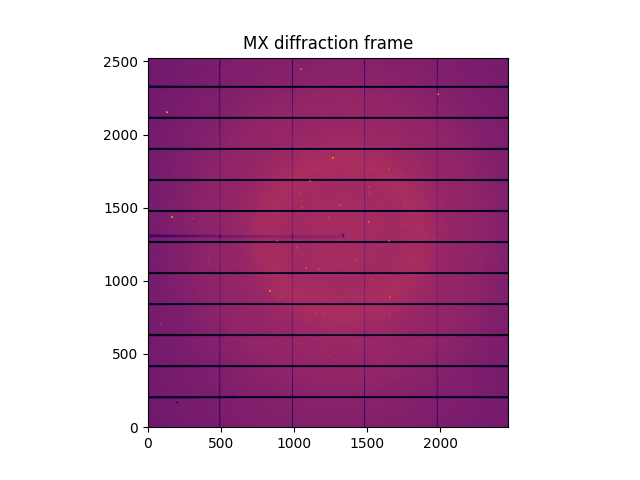

In [4]:
# Display the image using some helper function provided by pyFAI 
ax = jupyter.display(data)
_ = ax.set_title("MX diffraction frame")

## Azimuthal averaging



In [5]:
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
print(ai)

Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.033200e-10m
SampleDetDist= 3.000000e-01m	PONI= 2.254060e-01, 2.285880e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 300.000mm	Center: x=1329.000, y=1310.500 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


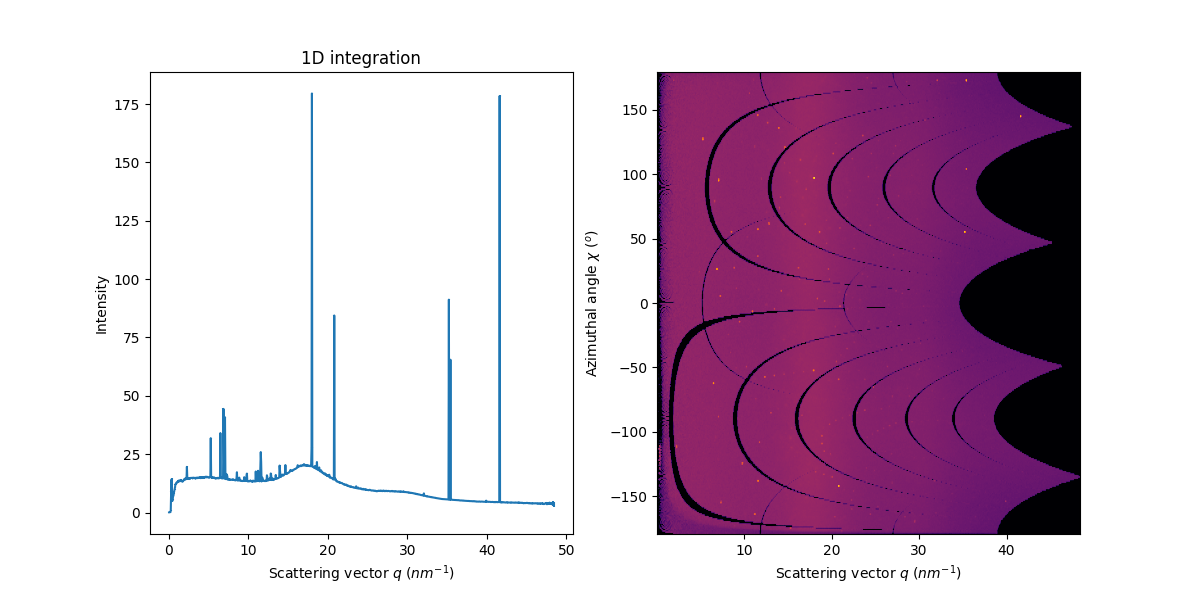

In [6]:
npt = 1000
mask = data<0
ai.detector.mask = mask
method = ("no", "csr", "cython")
res1d = ai.integrate1d(data, npt, method=method, error_model="poisson")
res2d = ai.integrate2d(data, npt, method=method)

fig,ax = subplots(1, 2, figsize=(12,6))
jupyter.plot1d(res1d, ax=ax[0])
jupyter.plot2d(res2d, ax=ax[1])
pass

Let's have a look at the distribution of pixel values at q=17 1/nm(i.e. the maximum of the ice-ring) and q=30 1/nm

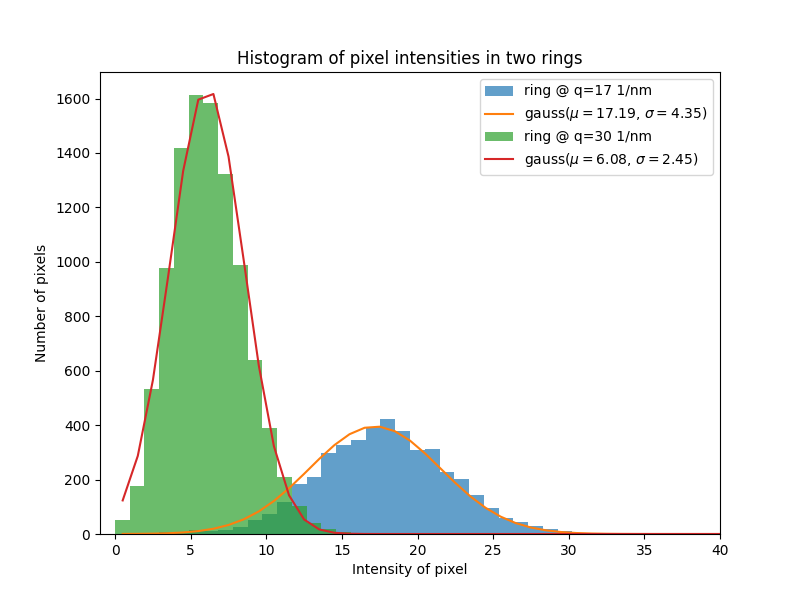

In [7]:
targets = 17, 30

fig, ax = subplots(1, figsize=(8, 6))
def gaussian(x, h, c, s):
    return h*numpy.exp(-(x-c)**2/(2*s*s))

for target in targets:
    idx = numpy.argmin(abs(target-res1d.radial))    
    key = list(ai.engines.keys())[0]
    csr = ai.engines[key].engine.lut
    values = data.ravel()[csr[1][csr[2][idx]:csr[2][idx+1]]]
    ax.hist(values, 42, range=(-1, 40), label=f"ring @ q={target} 1/nm", alpha=0.7)
    values = values[values>=0]
    v,c = numpy.histogram(values, values.max())
    c = numpy.argmax(v)
    s=1
    h = v.max()
    x = numpy.arange(values.max())+0.5 
    res = scipy.optimize.curve_fit(gaussian, x, v, [h,c,s])[0]
    ax.plot(x, gaussian(x, *res), label=r"gauss($\mu=$%.2f, $\sigma=$%.2f)"%(res[1], res[2]))
ax.set_xlim(-1, 40)
ax.legend()
ax.set_ylabel("Number of pixels")
ax.set_xlabel("Intensity of pixel")
_=ax.set_title(f"Histogram of pixel intensities in two rings")

Both rings have a bell-shape distribution and can be approximated by a Gaussian function.

In [8]:
# Numerical histogram of the last curve:
numpy.histogram(values, values.max())

(array([  52,  175,  533,  977, 1420, 1614, 1584, 1323,  987,  640,  390,
         210,  104,   39,   20,    9,    5,    2,    1,    2,    0,    0,
           0,    0,    1,    0,    1,    0,    1,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76

Pixel counting 84, 63, 58 and 52 are likely to be outsiders! 

If one considered the ensemble of pixels falling into a single azimuthal bin to follow the normal distrinution, here with an average of 6 and an associated deviation of 2.5, Any pixel above 15 should be considered a bragg-peak !

### Properties of the normal distribution:

/tmp/ipykernel_423684/1759106058.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f(k) for k in range(-4,5)])


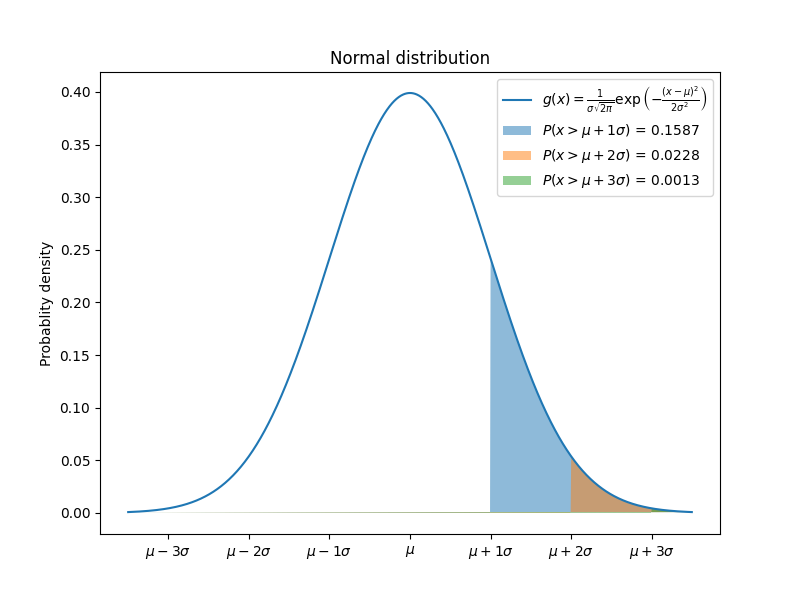

In [9]:
#Some properties of the Normal distribution:
fig, ax = subplots(1, figsize=(8, 6))

x = numpy.linspace(-3.5, 3.5, 1001)
g = lambda x: numpy.exp(-x*x/2)/numpy.sqrt(2*numpy.pi)
ax.plot(x, g(x), label=r"$g(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$")
f=lambda k: "$\mu"+(str(k)+"\sigma$" if k<0 else ("+"+str(k)+"\sigma$" if k>0 else "$"))
ax.set_xticklabels([f(k) for k in range(-4,5)])
y1 = g(x)
for t in range(1,4):
    y1[x<t] = 0
    ax.fill(x, y1, alpha=0.5, label=f"$P(x>\mu+{t}\sigma)$ = {0.5*(1-erf(t/numpy.sqrt(2))):6.4f}")
ax.set_ylabel("Probablity density")
ax.set_title("Normal distribution")
ax.legend(loc=1)
pass

The number of outlier pixels is very well characterized for this distibution: 
* 16% at 1 sigma
* 2% at 2 sigma 
* 0.1% at 3 sigma

### Uncertainties in azimuthal integration

First and formost one should make the distinction between *standard deviation* and *standard error of the mean*, which are both refered as `sigma`:
* **std**: the *standard deviation* correspond to the uncertainty about a pixel value, and this what we are interested in, in this tutorial
* **sem**: the uncertainty about the mean value, this correspond to the $std/\sqrt{size}$. Those are the uncertainties provided by pyFAI for the azimuthal integration

PyFAI provides 2 ways of assessing uncertainties: 

1. If the variance of pixels follows a law as function of their intensity, this variance can be propagated. The most typical case is for photon counting detector which follow Poisson's law, i.e. V = I. 
2. If one assumes there are no outliers in a ring, the variance can be calculated from the difference to the mean.

Let's see how those 2 uncertainties look like for the previous image:

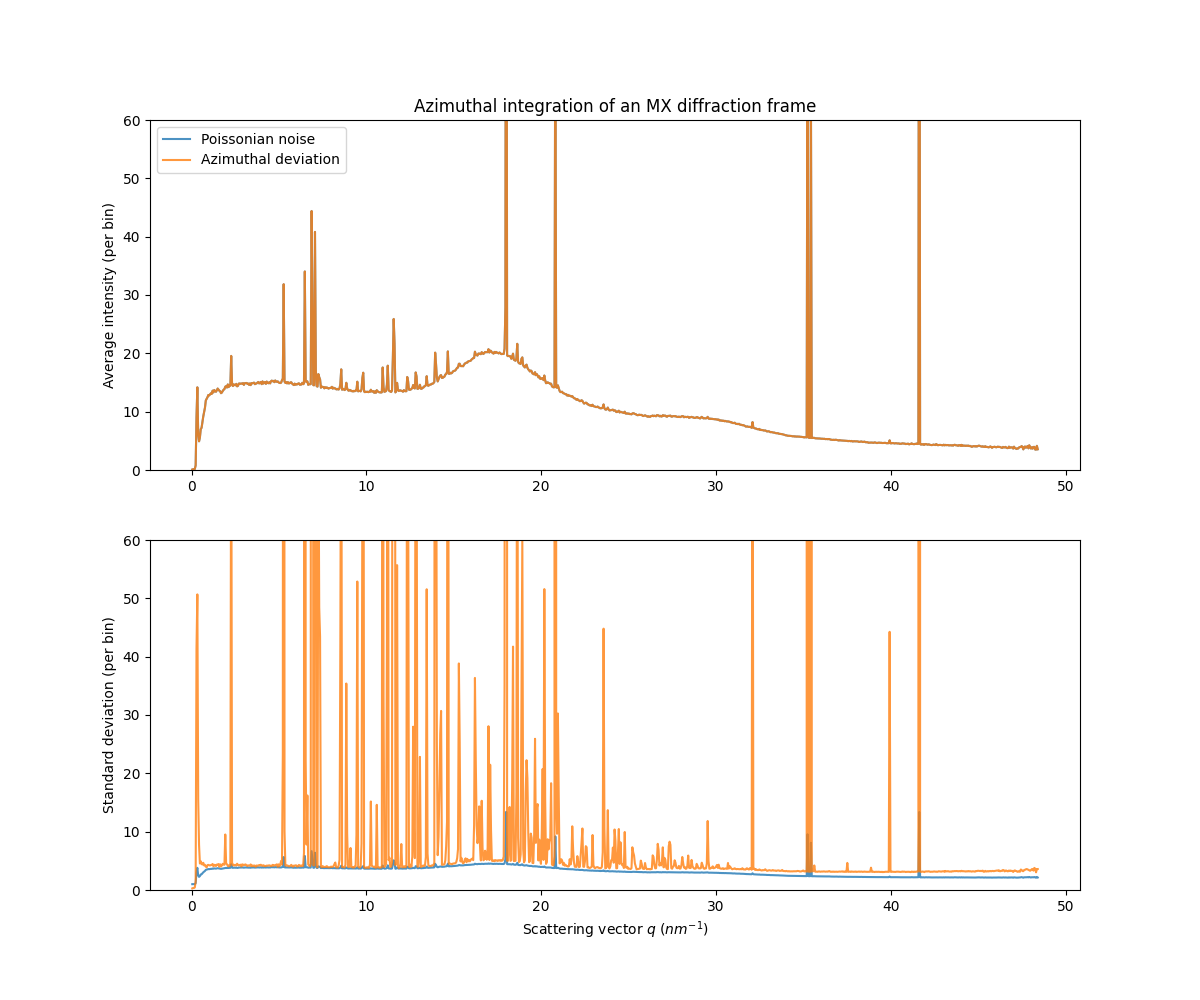

In [10]:
p0 = ai.sigma_clip_ng(data, npt, method=method, error_model="poisson", thres=0, max_iter=0)
a0 = ai.sigma_clip_ng(data, npt, method=method, error_model="azimuthal", thres=0, max_iter=0)

fig,ax = subplots(2, figsize=(12, 10))
ax[0].plot(p0.radial, p0.intensity, label=r"Poissonian noise", alpha=0.8) 
ax[0].plot(a0.radial, a0.intensity, label=r"Azimuthal deviation", alpha=0.8)
ax[0].legend()
ax[1].plot(p0.radial, numpy.sqrt(p0.sum_variance/p0.sum_normalization), label=r"Poissonian noise", alpha=0.8) 
ax[1].plot(a0.radial, numpy.sqrt(a0.sum_variance/a0.sum_normalization), label=r"Azimuthal deviation", alpha=0.8)
ax[0].set_ylim(0, 60)
ax[1].set_ylim(0, 60)
ax[1].set_xlabel(p0.unit.label)
ax[0].set_ylabel("Average intensity (per bin)")
ax[1].set_ylabel("Standard deviation (per bin)")
_=ax[0].set_title("Azimuthal integration of an MX diffraction frame")

## Sigma-clipping

The algorithm  consists in **iteratively** rejecting outliers from an ensemble based on their values and the mean/std of the ensemble, then to re-evaluate the mean/std until the ensemble is stable. 
The two main parameters are:

* The **number of cycles** in the iteration, it needs to be large enough to allow the distribution to converge. 3 to 5 cycles are usually enough.
* The **cut-off** for clipping data: data with $|I- <I>| > n \sigma_I$ are masked out. 

Let's see the effect after a single clipping (cycle=1) on the average and the uncertainties:

/tmp/ipykernel_423684/3328727823.py:11: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(p0.radial, numpy.sqrt(p1.sum_variance/p1.sum_normalization), label=r"Poissonian noise")


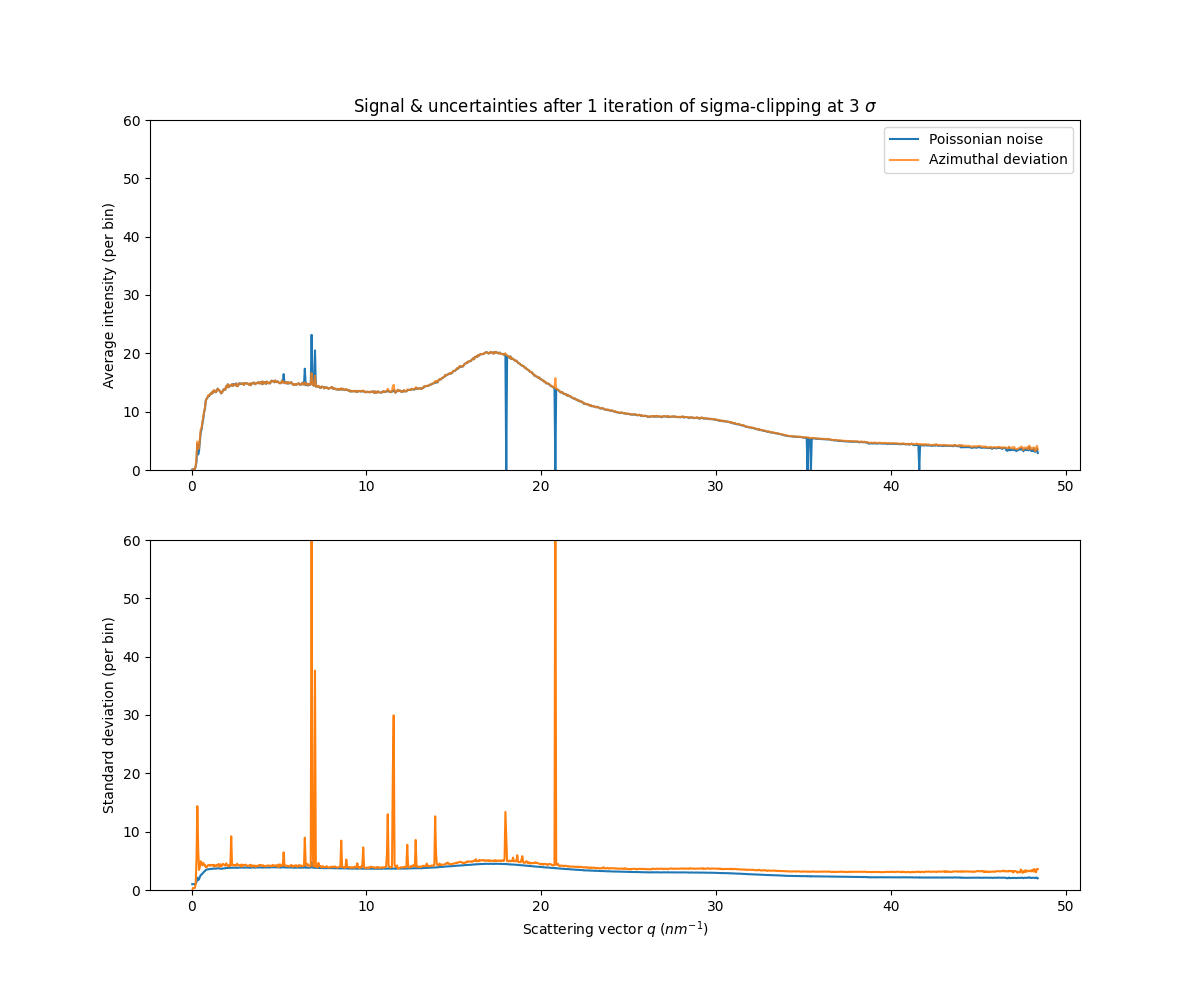

In [11]:
SNR = 3
cycle = 1

p1 = ai.sigma_clip_ng(data, npt, method=method, error_model="poisson", thres=SNR, max_iter=cycle)
a1 = ai.sigma_clip_ng(data, npt, method=method, error_model="azimuthal", thres=SNR, max_iter=cycle)

fig,ax = subplots(2, figsize=(12, 10))
ax[0].plot(p1.radial, p1.intensity, label=r"Poissonian noise") 
ax[0].plot(a1.radial, a1.intensity, label=r"Azimuthal deviation", alpha=0.8)
ax[0].legend()
ax[1].plot(p0.radial, numpy.sqrt(p1.sum_variance/p1.sum_normalization), label=r"Poissonian noise")
ax[1].plot(a0.radial, numpy.sqrt(a1.sum_variance/a1.sum_normalization), label=r"Azimuthal deviation")
 
ax[0].set_ylim(0, 60)
ax[1].set_ylim(0, 60)
ax[1].set_xlabel(p0.unit.label)
ax[0].set_ylabel("Average intensity (per bin)")
ax[1].set_ylabel("Standard deviation (per bin)")
_=ax[0].set_title(f"Signal & uncertainties after {cycle} iteration of sigma-clipping at {SNR} $\\sigma$")

This cut-off parameters can automatically be calculated from the Chauvenet criterion: 

What is the cut-off which would discard at worse a single pixel in the normal distribution ?

$$SNR = \sqrt{2log(size/ \sqrt{2 \pi})}$$


The *sigma-clipping* actually enforces a normal distribution in the remaining data-points after just a few cycles.

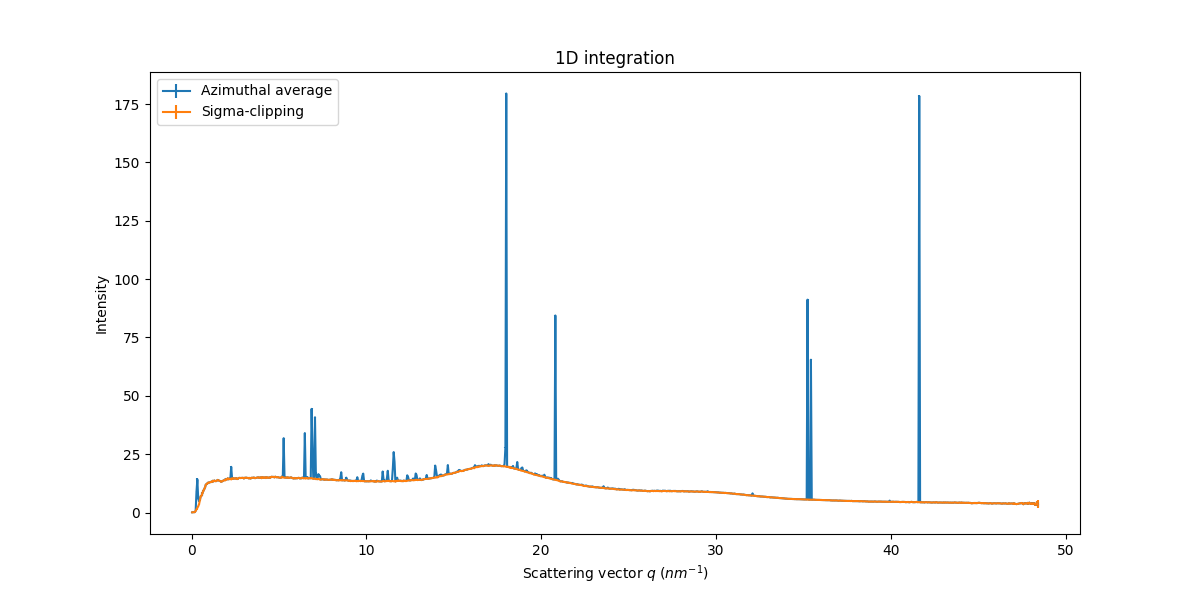

In [12]:
ai.detector.mask = mask
sc1d = ai.sigma_clip_ng(data, npt, method=method, error_model="azimuthal")

fig,ax = subplots(1, figsize=(12, 6))
jupyter.plot1d(res1d, ax=ax, label="Azimuthal average")
jupyter.plot1d(sc1d, ax=ax, label="Sigma-clipping")
pass

Take-home message:
*Sigma-clipping* provides us with a smooth background and the associated uncertainty. There are 2 main parameters:
* the number of iteration of clipping (often 3 to 5)
* the cut-off for discarding pixels. We use an adaptative Chauvenet threshold which depends on the size of the distibution, usually between 3 and 5.

There are 2 ways of calculating the deviation:
* from the Poisson statistics
* from the deviation to the mean

The later has been developped for detector being non-poissonian, like the Jungdrau which is an integrating detector.

### A word about performances:

Because of its iterative nature, the sigma-clipping is performing several azimuthal integration and takes a lot of time. This is why this algorithm has been ported to OpenCL to run on GPU. Here are

Do not guess, measure !

In [13]:
#Performance comparison between CPU (multi-core) implementation and GPU implementation
%timeit ai.sigma_clip_ng(data, npt, method=("no", "csr", "cython"), error_model="azimuthal")
%timeit ai.sigma_clip_ng(data, npt, method=("no", "csr", "opencl"), error_model="azimuthal")

73.5 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54 ms ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The speed-up observed is almost 24x but it varies a lot between the (CPU/GPU) couple compared (Xeon E5-1650/A5000).

## Application to the sparsification of MX/SSX data

When data cannot be written to disk because of the data-deluge, why not saving only the intensity of Bragg-peaks ?!

In [14]:
method = res1d.method
lut = ai.engines[method].engine.lut
peak_finder = OCL_PeakFinder(lut, 
                             image_size=numpy.prod(ai.detector.shape),
                             unit=res1d.unit,
                             bin_centers=res1d.radial,
                             radius=ai.array_from_unit(unit=res1d.unit),
                             mask=ai.detector.mask)

%time sep = peak_finder.sparsify(data, error_model="azimuthal")
print(f"Number of Bragg pixels found: {len(sep.index)}")

CPU times: user 1.95 ms, sys: 1.02 ms, total: 2.97 ms
Wall time: 10 ms
Number of Bragg pixels found: 16696


In [15]:
peak_finder.reset_log()
peak_finder.set_profiling(True)
%timeit peak_finder.sparsify(data, error_model="azimuthal")
print("\n".join(peak_finder.log_profile(True)))
peak_finder.set_profiling(False)

14.2 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_PeakFinder
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw H->D image (  811):    1.760    2.412    2.604    2.374    0.217
                                 cast s32_to_float (  811):    0.172    0.688    0.706    0.581    0.164
                                         memset_ng (  811):    0.001    0.001    0.008    0.001    0.000
                                       corrections (  811):    0.498    0.706    2.178    1.152    0.739
                                   csr_sigma_clip4 (  811):    3.884    4.203   10.786    6.336    2.999
                                    memset counter (  811):    0.001    0.001    0.001    0.001    0.000
                                       peak_search (  811):    0.690    0.780    1.531    0.779    0.062
                 

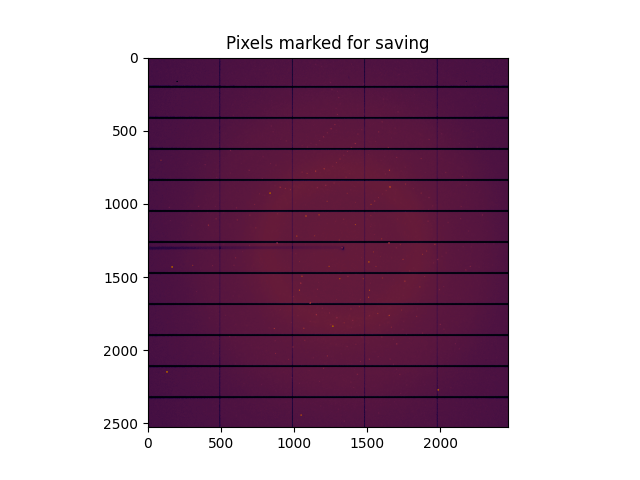

In [16]:
ax = jupyter.display(data)
_ = ax.set_title("Pixels marked for saving")
lmask = numpy.ones(data.size, dtype=bool)
lmask[sep[0]]=0
shadow = numpy.outer(lmask, numpy.array([0, 0, 0, 100], dtype=numpy.uint8)).reshape(data.shape+(4,))
ax.imshow(shadow)

## Presentation of ID29: Serial Synchrotron Crystallography beamline at ESRF
https://www.esrf.fr/home/UsersAndScience/Experiments/MX/About_our_beamlines/id29/overview.html

Some key figures:
* ID29 operates a Jungfrau 4M detector at 1kHz, 16bpp raw data
* 8 GB/s of raw data, 16 GB/s after pedestal correction
* The storage cluster can only cope with 2GB/s (maximum guaranteed)
* The data needs to be compressed by a factor 8.
* The Jungfrau detector being an integrating detector, the background noise will degrade the compression ratio of bitshuffle-LZ4 compared to Eiger detectors.

Three options:
* operate at lower repetition rate: incompatible with serial crystallography
* save only a fraction of the frames using a *Veto-*algorithm (--> X-FEL)
* save only pixels belonging to Bragg-peaks (new approach ?)

### Application for the compression of an SSX dataset:

You will find the needed data in this directory:
https://www.silx.org/pub/pyFAI/pyFAI_UM_2022/SSX/

The parameters used to compress 1000 frames of an Eiger4M are:
* The exerimental geometry and the mask for the detector
* 1000 azimuthal bins
* An azimuthal error model
* The cut-off for harvesting pixels is 2 sigma, thus 2% of background pixels should be picked as well
* Polarization factor of 0.99
which make the following command line:

```
sparsify-Bragg -p geometry.poni -m mask.msk -P 0.99 --bins 1000 -b ID29 \
               --cutoff-pick 2 --error-model azimuthal --noise 0.1\
               --dummy 65500 --delta-dummy 500 \
               -o lysozyme_azim.h5 lysozyme_Gd_4_1_data_000001.h5
```

The compression factor obtained is here 6.5x, the speed is about 40 fps when reading data via a 1Gbit NFS link. Compression speeds of 500 to 1000 fps were measured when treating data in memory.

Visualize the generated file with either `silx view` or the `h5web` HDF5 file viewer for jupyter-lab

#### Data can be densified again with:
```
densify-Bragg lysozyme_azim.h5 -o lysozyme_dense.h5
```
The densification takes place at ~100fps while reading and writing depend mostly on the type of drive.

### Validation of sparsification on rotationnal dataset with XDS

There is a rotationnal dataset collected by Dectris on insulin and available as part of their demonstration dataset for the Eiger4M in the folder named "rotationnal"

This dataset has been sparsified with this command:

```
sparsify-Bragg -p geometry.poni -m mask.npy -P 0.99 --bins 500 \
               --dummy=4e9 --delta-dummy=1e9 \
               --cutoff-pick 2 --error-model azimuthal --noise 0.1\
               -o sparse.h5 ../collect_01_00001_master.h5
```

The dense dataset is obtained with densify-Bragg from the *FabIO* package:
```
densify-Bragg -O eiger sparse.h5 -o dense_000001.h5
```
Mind to export the dataset in Eiger-format !

Once the master file and the *XDS.INP* are copied, one can reduce the dataset with **XDS**:
```
/opt/XDS/xds_par
```
and compare the `CORRECT.LP` files with *meld* for example.

## Application to the peak extraction of MX/SSX data

Instead of saving pixel, one could perform the peak integration, in the same way as `PeakFinder8` does:

### *PeakFinder8*
The *peakfinder8* is the core algorithm for assessing the quality of a single frame in serial crystallography and was initially implemented in C++ within the [cheetah](https://www.desy.de/~barty/cheetah/Cheetah/SFX_hitfinding.html) [1]

This algorithm is called *peakfinder8* because it consits of 8 subsequent steps perfromed on evry single frame:

1. perfrom the azimuthal integration with uncertainety propagation
2. discard pixels which differ by more than N-sigma from the mean and cycle to 1 about 3 to 5 times
3. pick all pixels with I > mean + min(N*sigma, noise)
4. such pixel is a peak if it is the maximum of the 3x3 or 5x5 patch and there are *connected* pixels in the patch with their intensity above the previous threshold.
5. subtract background and sum the signal over the patch
6. return the index of the peak, the integrated signal and the center of mass of the peak
7. exclude neighboring peaks (un-implemented)
8. Validate the frame if there are enough peaks found.

There is a attempt to implement *peakfinder8* on GPU within the pyFAI.
The steps 1+2 correspond to the *sigma-clipping* algorithm and enforce an azimuthal, normal distribution for the background.

This algorithm has a python wrapper available from https://github.com/tjlane/peakfinder8


[1] A. Barty, R. A. Kirian, F. R. N. C. Maia, M. Hantke, C. H. Yoon, T. A. White, and H. N. Chapman, "Cheetah: software for high-throughput reduction and analysis of serial femtosecond x-ray diffraction data", J Appl Crystallogr, vol. 47, pp. 1118-1131 (2014)



In [17]:
#Installation of a local copy of the Cython-bound peakfinder8
targeturl = "https://github.com/kif/peakfinder8"
targetdir = posixpath.split(targeturl)[-1]
if os.path.exists(targetdir):
    shutil.rmtree(targetdir, ignore_errors=True)
pwd = os.getcwd()
try:
    os.system("git clone " + targeturl)
    os.chdir(targetdir)
    os.system(sys.executable + " setup.py build")    
except exception as err:
    print(err)
finally:
    os.chdir(pwd)
sys.path.append(pwd+"/"+glob.glob(f"{targetdir}/build/lib*")[0])

Clonage dans 'peakfinder8'...


running build
running build_py
creating build
creating build/lib.linux-x86_64-3.9
creating build/lib.linux-x86_64-3.9/ssc
copying ssc/mapreduce.py -> build/lib.linux-x86_64-3.9/ssc
copying ssc/peak.py -> build/lib.linux-x86_64-3.9/ssc
copying ssc/evt.py -> build/lib.linux-x86_64-3.9/ssc
copying ssc/__init__.py -> build/lib.linux-x86_64-3.9/ssc
running build_ext
building 'ssc.peakfinder8_extension' extension
creating build/temp.linux-x86_64-3.9
creating build/temp.linux-x86_64-3.9/ext
creating build/temp.linux-x86_64-3.9/ext/peakfinder8
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -ffile-prefix-map=/build/python3.9-RNBry6/python3.9-3.9.2=. -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -ffile-prefix-map=/build/python3.9-RNBry6/python3.9-3.9.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -Iext/peakfinder8 -I/reg/g/psdm/sw/releases/ana-current/arch/x86_64-r

In file included from /home/jerome/.venv/py39/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960,
                 from /home/jerome/.venv/py39/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jerome/.venv/py39/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from ext/peakfinder8/peakfinder8_extension.cpp:346:
/home/jerome/.venv/py39/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /usr/include/python3.9/unicodeobject.h:1026,
                 from /usr/include/python3.9/Python.h:97,
                 from ext/peakfinder8/peakfinder8_extension.cpp:16:
ext/peakfinder8/peakfinder8_extension.cpp: In function ‘int __Pyx_P

x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -ffile-prefix-map=/build/python3.9-RNBry6/python3.9-3.9.2=. -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -ffile-prefix-map=/build/python3.9-RNBry6/python3.9-3.9.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -Iext/peakfinder8 -I/reg/g/psdm/sw/releases/ana-current/arch/x86_64-rhel6-gcc44-opt/geninc/ -I/home/jerome/.venv/py39/lib/python3.9/site-packages/numpy/core/include -I/home/jerome/.venv/py39/include -I/usr/include/python3.9 -c ext/peakfinder8/peakfinders.cpp -o build/temp.linux-x86_64-3.9/ext/peakfinder8/peakfinders.o


ext/peakfinder8/peakfinders.cpp: In function ‘int peakfinder3(tPeakList*, float*, char*, long int, long int, long int, long int, float, float, long int, long int, long int)’:
ext/peakfinder8/peakfinders.cpp:319:15: warning: variable ‘thisr’ set but not used [-Wunused-but-set-variable]
  319 |       float   thisr;
      |               ^~~~~
ext/peakfinder8/peakfinders.cpp:176:8: warning: variable ‘total’ set but not used [-Wunused-but-set-variable]
  176 |  float total;
      |        ^~~~~
ext/peakfinder8/peakfinders.cpp: In function ‘int peakfinder8(tPeakList*, float*, char*, float*, long int, long int, long int, long int, float, float, long int, long int, long int)’:
ext/peakfinder8/peakfinders.cpp:463:8: warning: variable ‘total’ set but not used [-Wunused-but-set-variable]
  463 |  float total;
      |        ^~~~~
ext/peakfinder8/peakfinders.cpp:507:7: warning: variable ‘lminr’ set but not used [-Wunused-but-set-variable]
  507 |  long lminr, lmaxr;
      |       ^~~~~
ext/peakfi

x86_64-linux-gnu-g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-z,relro -g -fwrapv -O2 -g -ffile-prefix-map=/build/python3.9-RNBry6/python3.9-3.9.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.9/ext/peakfinder8/peakfinder8_extension.o build/temp.linux-x86_64-3.9/ext/peakfinder8/peakfinders.o -L/reg/g/psdm/sw/releases/ana-current/arch/x86_64-rhel6-gcc44-opt/lib -o build/lib.linux-x86_64-3.9/ssc/peakfinder8_extension.cpython-39-x86_64-linux-gnu.so
running build_scripts
creating build/scripts-3.9
copying and adjusting scripts/ssc.pp_cheetah -> build/scripts-3.9
changing mode of build/scripts-3.9/ssc.pp_cheetah from 644 to 755


In [18]:
# Create some compatibility layer:
from ssc.peakfinder8_extension import peakfinder_8
img = data.astype("float32")
r = ai._cached_array['q_center'].astype("float32")
imask = (1-mask).astype("int8")
max_num_peaks = 10000
asic_nx = img.shape[-1]
asic_ny = img.shape[0]
nasics_x = 1
nasics_y = 1
adc_threshold = 2.0
minimum_snr = 3.0
min_pixel_count = 9
max_pixel_count = 999
local_bg_radius = 2
accumulated_shots = 1
min_res = 0
max_res = 3000

ref = peakfinder_8(max_num_peaks,
                   img, imask, r, 
                   asic_nx, asic_ny, nasics_x, nasics_y, 
                   adc_threshold, minimum_snr,
                   min_pixel_count, max_pixel_count, local_bg_radius)

In [19]:
%%timeit
ref = peakfinder_8(max_num_peaks,
                   img, imask, r, 
                   asic_nx, asic_ny, nasics_x, nasics_y, 
                   adc_threshold, minimum_snr,
                   min_pixel_count, max_pixel_count, local_bg_radius)

134 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print("Number of peak found: ", len(ref[0]), len(ref[1]), len(ref[2]))

Number of peak found:  189 189 189


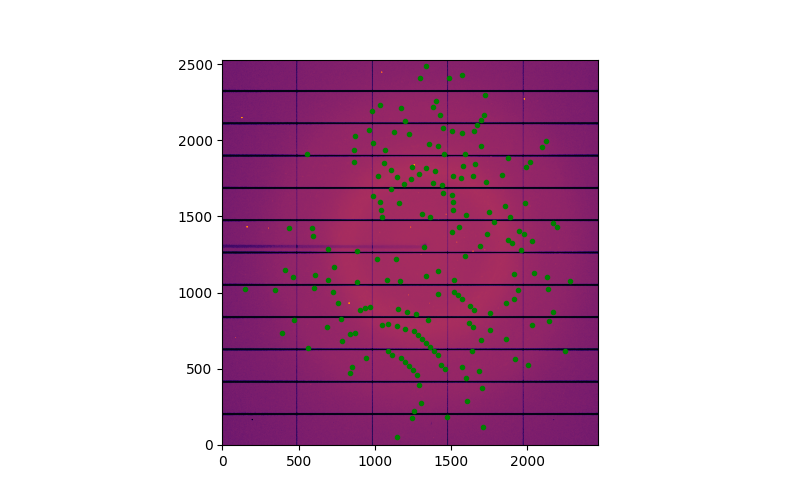

In [21]:
#Display the peaks
fig, ax = subplots(figsize=(8,5))
jupyter.display(data, ax=ax)
_ = ax.plot(ref[0], ref[1], ".g")

### Peakfinder as implemented in pyFAI:

1. Perform the sigma-clipping, as préviously
2. Subtract the background obtained from sigma-clipping from intensity and compare it with the treshold `n*sqrt(sigma² + noise²)`
3. For each pixel, consider the patch of 3x3 or 5x5 pixels around it. 
   * Is the current pixel is the maximum of its patch ?
   * Are there enough pixels in the patch with a signal higher than the treshold ?
   * Report the centroid over the patch and the integrated intensity (with uncertainty propagation)

In [22]:
unit = res1d.unit
integrator = ai.setup_CSR(ai.detector.shape, 1000, mask=mask, unit=unit, split="no", scale=False)
pf = OCL_PeakFinder(lut, 
                    image_size=data.size,
                    bin_centers=res1d.radial,
                    radius=ai._cached_array[unit.name.split("_")[0] + "_center"],
                    mask=mask,
                    block_size=256,
                    # platformid=1,
                    # deviceid=1,
                    unit=unit) 
print(f"Working on device {pf.ctx.devices[0]} with block_size {pf.block_size}")
kwargs = {"data": data, 
          "error_model":"azimuthal", 
         }
print(f"Number of high intensity pixels at stage #3: {pf.count(**kwargs ,cycle=5, cutoff_clip=5, cutoff_pick=3.0)}\n\
Number of peaks identified at stage #6: {pf._count8(**kwargs, cycle=5, cutoff_pick=3.0)}")

Working on device <pyopencl.Device 'gfx900' on 'AMD Accelerated Parallel Processing' at 0x3ec5530> with block_size 256
Number of high intensity pixels at stage #3: 16712
Number of peaks identified at stage #6: 341


In [23]:
# Visualization of the performances:
res8 = pf.peakfinder8(data, error_model="azimuthal", cycle=5, cutoff_pick=3, noise=2, connected=5, patch_size=7)
print(len(res8), res8.dtype)

239 [('index', '<i4'), ('intensity', '<f4'), ('sigma', '<f4'), ('pos0', '<f4'), ('pos1', '<f4')]


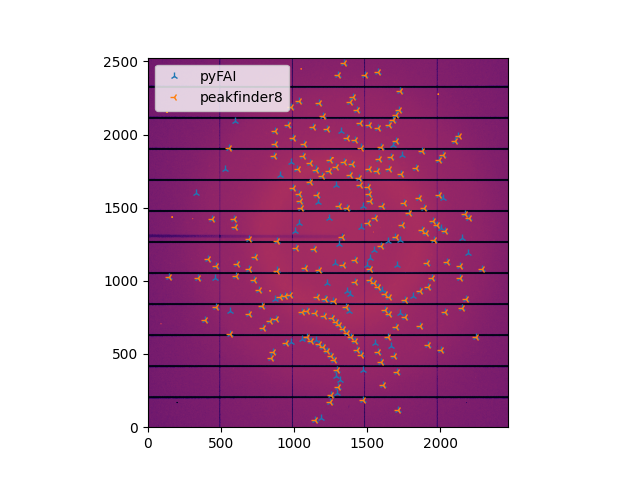

In [24]:
ax = jupyter.display(data)
ax.plot(res8["pos1"], res8["pos0"], "2", alpha=1, label="pyFAI")
ax.plot(ref[0], ref[1], "3", alpha=1, label="peakfinder8")
_=ax.legend()

In [25]:
# Performance measurement:
pf.reset_log()
pf.set_profiling(True)
pf.peakfinder8(**kwargs, cycle=5, cutoff_pick=3, noise=2, connected=3, patch_size=3)
%timeit pf.peakfinder8(**kwargs, cycle=5, cutoff_pick=3, noise=2, connected=3, patch_size=3)
print("\n".join(pf.log_profile(True)))
pf.set_profiling(False)

12 ms ± 861 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_PeakFinder
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw H->D image (  812):    2.312    2.367    2.605    2.376    0.047
                                 cast s32_to_float (  812):    0.377    0.682    0.696    0.590    0.114
                                         memset_ng (  812):    0.001    0.004    0.019    0.004    0.001
                                       corrections (  812):    0.631    0.766    2.096    1.104    0.621
                                   csr_sigma_clip4 (  812):    2.847    3.139   10.336    4.982    3.063
                                    memset counter (  812):    0.001    0.001    0.001    0.001    0.000
                                       peakfinder8 (  812):    1.200    1.203    5.935    1.261    0.386
                   

### Application of the peakfinder on SSX data:

As previously, one can perform the peak-picking for the serial-crystallophy dataset:
```
peakfinder -p geometry.poni -m mask.msk -P 0.99 --bins 1000 -b ID29 --cutoff-pick 3 --error-model azimuthal --noise 0.1 -o lysozyme_pf_azim.h5 --patch-size 5 --connected 3 lysozyme_Gd_4_1_data_000001.h5 --dummy=65500 --delta-dummy=500 --profile
```

Visualize the generated file with either `silx view` or the `h5web` HDF5 file viewer for jupyter-lab


## Conclusion

* PyFAI provides advanced background anlaysis routines which can be used in single/serial crystallography to:
    - Compress raw data by discading pixel of lesser interrest
    - Extract peak position for indexing
* The code is written in OpenCL which runs efficiently on any GPU (tested on Nvidia, AMD and Intel hardware).
* A GPU usually outperforms a CPU of the same price by a factor 5x

The GPU used in this described in this table (from 2017, so this is a 5 y-o GPU):

![GPU comparison table](IMG0054516.png)
